In [1]:
import os
import sys
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from rich.console import Console
from rich.markdown import Markdown

# Add parent directory to path to import from src
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from src.models import (
    GraphState, BusinessAnalysis, ModuleDecomposition, 
    DataSchemas, PseudoCode, TechnicalSpecification
)
from src.prompts import (
    ANALYZE_PROMPT, DECOMPOSE_PROMPT, SCHEMA_PROMPT,
    PSEUDOCODE_PROMPT, SYNTHESIZE_PROMPT
)

# Load environment variables
load_dotenv()


True

### 1. Configure LLM with Structured Outputs

Using OpenAI's GPT-4o-mini with structured output capability via Pydantic models.

In [3]:
# Initialize OpenAI LLM
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.5,
    api_key=os.getenv("OPENAI_API_KEY")
)


### 2. Define Business Requirement

Testing with a product recommendation system use case.

In [4]:
requirement = "Build a system that recommends products to users based on browsing history."

### 3. Define Workflow Nodes

Each node represents a stage in the conversion pipeline.

In [5]:
def analyze_requirements(state: GraphState) -> GraphState:
    """Analyze business requirements and extract structured information."""
    print("\n📊 Node 1: Analyzing requirements...")
    
    structured_llm = llm.with_structured_output(BusinessAnalysis)
    analysis = structured_llm.invoke(
        ANALYZE_PROMPT.format(requirement=state.requirement)
    )
    
    state.title = analysis.title
    state.analysis = analysis
    
    print(f"   ✓ Title: {analysis.title}")
    print(f"   ✓ Business Goal: {analysis.business_goal}")
    print(f"   ✓ Actors: {len(analysis.actors)} identified")
    
    return state

In [6]:
def decompose_modules(state: GraphState) -> GraphState:
    """Decompose system into modules/components."""
    print("\n🏗️  Node 2: Decomposing into modules...")
    
    structured_llm = llm.with_structured_output(ModuleDecomposition)
    modules = structured_llm.invoke(
        DECOMPOSE_PROMPT.format(
            analysis=state.analysis.model_dump_json(indent=2)
        )
    )
    
    state.modules = modules
    
    print(f"   ✓ Modules identified: {len(modules.modules)}")
    for module in modules.modules:
        print(f"      - {module.name}")
    
    return state

In [7]:
def design_schemas(state: GraphState) -> GraphState:
    """Design data schemas for the system."""
    print("\n🗄️  Node 3: Designing data schemas...")
    
    structured_llm = llm.with_structured_output(DataSchemas)
    schemas = structured_llm.invoke(
        SCHEMA_PROMPT.format(
            analysis=state.analysis.model_dump_json(indent=2),
            modules=state.modules.model_dump_json(indent=2)
        )
    )
    
    state.schemas = schemas
    
    print(f"   ✓ Schemas designed: {len(schemas.schemas)}")
    for schema in schemas.schemas:
        print(f"      - {schema.entity} ({len(schema.fields)} fields)")
    
    return state

In [8]:
def generate_pseudocode(state: GraphState) -> GraphState:
    """Generate pseudo-code for core workflows."""
    print("\n💻 Node 4: Generating pseudo-code...")
    
    structured_llm = llm.with_structured_output(PseudoCode)
    pseudocode = structured_llm.invoke(
        PSEUDOCODE_PROMPT.format(
            analysis=state.analysis.model_dump_json(indent=2),
            modules=state.modules.model_dump_json(indent=2),
            schemas=state.schemas.model_dump_json(indent=2)
        )
    )
    
    state.pseudocode = pseudocode
    
    print(f"   ✓ Pseudo-code sections: {len(pseudocode.sections)}")
    for section in pseudocode.sections:
        print(f"      - {section.name}")
    
    return state

In [9]:
def synthesize_report(state: GraphState) -> GraphState:
    """Synthesize all information into a comprehensive report."""
    print("\n📝 Node 5: Synthesizing technical specification...")
    
    structured_llm = llm.with_structured_output(TechnicalSpecification)
    spec = structured_llm.invoke(
        SYNTHESIZE_PROMPT.format(
            requirement=state.requirement,
            analysis=state.analysis.model_dump_json(indent=2),
            modules=state.modules.model_dump_json(indent=2),
            schemas=state.schemas.model_dump_json(indent=2),
            pseudocode=state.pseudocode.model_dump_json(indent=2)
        )
    )
    
    state.final_report = spec.markdown_content
    
    print(f"   ✓ Report generated ({len(spec.markdown_content)} characters)")
    
    return state

### 4. Build LangGraph Workflow

Construct the state graph with nodes and edges.

In [11]:
# Initialize the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("analyze", analyze_requirements)
workflow.add_node("decompose", decompose_modules)
workflow.add_node("schemas", design_schemas)
workflow.add_node("pseudocode", generate_pseudocode)
workflow.add_node("synthesize", synthesize_report)

# Define edges (linear flow)
workflow.set_entry_point("analyze")
workflow.add_edge("analyze", "decompose")
workflow.add_edge("decompose", "schemas")
workflow.add_edge("schemas", "pseudocode")
workflow.add_edge("pseudocode", "synthesize")
workflow.add_edge("synthesize", END)

# Compile the graph
app = workflow.compile()


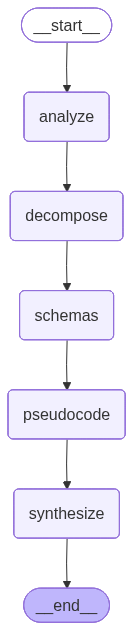

In [12]:
display(Image(app.get_graph().draw_mermaid_png()))

### 6. Execute the Pipeline

Run the complete workflow on our test requirement.

In [13]:
print("Starting pipeline execution...")


# Create initial state
initial_state = GraphState(requirement=requirement)

# Execute workflow
result = app.invoke(initial_state)

print("\n" + "=" * 80)
print("✨ Pipeline execution completed!")
print("=" * 80)

Starting pipeline execution...

📊 Node 1: Analyzing requirements...
   ✓ Title: Product Recommendation System
   ✓ Business Goal: To enhance user experience by providing personalized product recommendations based on their browsing history.
   ✓ Actors: 4 identified

🏗️  Node 2: Decomposing into modules...
   ✓ Modules identified: 10
      - User Tracking Module
      - Data Analysis Module
      - Recommendation Engine Module
      - Recommendation Display Module
      - User Feedback Module
      - Security Module
      - API Gateway Module
      - Monitoring and Logging Module
      - Background Job Processing Module
      - Frontend User Interface Module

🗄️  Node 3: Designing data schemas...
   ✓ Schemas designed: 6
      - Users (6 fields)
      - BrowsingHistory (4 fields)
      - Products (6 fields)
      - Recommendations (5 fields)
      - UserFeedback (6 fields)
      - Sessions (4 fields)

💻 Node 4: Generating pseudo-code...
   ✓ Pseudo-code sections: 3
      - Main User Wor

### 7. Display Generated Technical Specification

Rendering the final report with Rich markdown formatting.

In [14]:
# Extract the final report
final_report = result.get("final_report", "No report generated")

# Display using Rich
console = Console()
console.print(Markdown(final_report))

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                             Technical Specification: Product Recommendation System                              ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                               1. Executive Summary                                                

The Product Recommendation System aims to enhance user experience by providing personalized product recommendations
based on users' browsing history. By analyzing user data and preferences, the system will deliver tailored         
suggestions, improving user engagement and satisfaction.                                                           


                                         2. Business Requirement Analysis                                          

 • Core Business Goal                                                                                              
   To enhance user experience by providing personalized product recommendations based on their browsing history.   
 • Key Actors/Users                                                                                                
    • End Users                                                                                                    
    • System Administrators                                                                                        
    • Product Managers                                                                                             
    • Data Analysts                                                                                                
 • Functional Expectations                                                                                         
    • Track user browsing history                                                                                  
    • Analyze browsing patterns to identify preferences                                                            
    • Generate personalized product recommendations                                                                
    • Display recommendations on user interface                                                                    
    • Allow users to provide feedback on recommendations                                                           
 • Non-Functional Constraints                                                                                      
                                                                                                                   
     Category         Description                                                                                  
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
     Performance      The system should respond to user requests for recommendations within 2 seconds.             
     Scalability      The system must handle up to 10,000 concurrent users without degradation in performance.     
     Security         User data must be encrypted both in transit and at rest to protect user privacy.             
     Explainability   The system should provide users with insights into why specific products are recommended.    
     Availability     The system should maintain 99.9% uptime to ensure users can access recommendations at all    
                      times.                                                                                       
                                                                                                                   


                                              3. System Architecture                                               

                                                  Module Overview                                                  

                                              